In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from gensim.models.keyedvectors import Word2VecKeyedVectors
import os

## 데이터 준비와 확인

In [2]:
import pandas as pd

# 데이터를 읽어봅시다.
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 데이터로더 구성

In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any')
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어
        X_train.append(temp_X)
    
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '' ,''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다.
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']] +[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다.
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다.
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:]) #[1:]를 통해 <BOS>  를 제외

# 여러 개의 숫자 벡터로 encode된 문잘을 한꺼번에 원래대로 decode하는 함수입니다.
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3) 모델 구성을 위한 데이터 분석 및 가공

---

* 데이터셋 내 문장 길이 분포
* 적절한 최대 문장 길이 지정
* keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [6]:
X_train[0]

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]

In [7]:
print(get_decoded_sentence(X_train[0], index_to_word))

더 빙 . . 진짜 짜증 나 네요 목소리


In [8]:
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2
word_to_index["<UNUSED>"] = 3


In [9]:
#index_to_word[3]

In [10]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tikens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다.
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준펀차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2 * 표준편차)로 한다면,
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준펀차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [11]:
X_train_post = tf.keras.preprocessing.sequence.pad_sequences(X_train, value=word_to_index["<PAD>"], padding='post', maxlen=maxlen)
X_test_post = tf.keras.preprocessing.sequence.pad_sequences(X_test, value=word_to_index["<PAD>"], padding='post', maxlen=maxlen)
print(X_train_post.shape)
print(X_test_post.shape)

(146182, 41)
(49157, 41)


In [12]:
X_train_pre = tf.keras.preprocessing.sequence.pad_sequences(X_train, value=word_to_index["<PAD>"], padding='pre', maxlen=maxlen)
X_test_pre = tf.keras.preprocessing.sequence.pad_sequences(X_test, value=word_to_index["<PAD>"], padding='pre', maxlen=maxlen)
print(X_train_pre.shape)
print(X_test_pre.shape)

(146182, 41)
(49157, 41)


## 4) 모델 구성 및 validation set 구성

---

모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

### RNN

In [13]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능 하이파라미터)

model_RNN = tf.keras.Sequential()
model_RNN.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_RNN.add(tf.keras.layers.LSTM(8))  # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model_RNN.add(tf.keras.layers.Dense(8, activation='relu'))
model_RNN.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model_RNN.summary()

 #
# validation set 10000건 분리
X_val_post = X_train_post[:10000]
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train_post = X_train_post[10000:]
partial_y_train = y_train[10000:]

print(partial_X_train_post.shape)
print(partial_y_train.shape)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________
(136182, 41)
(136182,)


### CNN

In [14]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능 하이파라미터)

model_CNN = tf.keras.Sequential()
model_CNN.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_CNN.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_CNN.add(tf.keras.layers.MaxPooling1D(5))
model_CNN.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_CNN.add(tf.keras.layers.GlobalMaxPooling1D())
model_CNN.add(tf.keras.layers.Dense(8, activation='relu'))
model_CNN.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model_CNN.summary()

 #
# validation set 10000건 분리
X_val_post = X_train_post[:10000]
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train_post = X_train_post[10000:]
partial_y_train = y_train[10000:]

print(partial_X_train_post.shape)
print(partial_y_train.shape)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

### 단일 GlobalMaxPooling1D()

In [15]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능 하이파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_SG = tf.keras.Sequential()
model_SG.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_SG.add(tf.keras.layers.GlobalMaxPooling1D())
model_SG.add(tf.keras.layers.Dense(8, activation='relu'))
model_SG.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model_SG.summary()
 #
# validation set 10000건 분리
X_val_post = X_train_post[:10000]
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train_post = X_train_post[10000:]
partial_y_train = y_train[10000:]

print(partial_X_train_post.shape)
print(partial_y_train.shape)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________
(136182, 41)
(136182,)


In [16]:
#vocab_size = 10000  # 어휘 사전의 크기입니다(10,000개이 단어)
#word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능 하이파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
#model = tf.keras.Sequential()

In [17]:
# validation set 10000건 분리
#X_val_post = X_train_post[:10000]
#y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
#partial_X_train_post = X_train_post[10000:]
#partial_y_train = y_train[10000:]

#print(partial_X_train_post.shape)
#print(partial_y_train.shape)

## 5) 모델 훈련 개시

---

## RNN

In [18]:
model_RNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.

history_RNN = model_RNN.fit(partial_X_train_post, partial_y_train, epochs=epochs, batch_size=512, validation_data=(X_val_post, y_val), verbose=1)

print('-'*40)

results_RNN = model_RNN.evaluate(X_test_post, y_test, verbose=2)
print(results_RNN)

Epoch 1/20
266/266 [==============================] - 5s 7ms/step - loss: 0.5444 - accuracy: 0.7044 - val_loss: 0.3684 - val_accuracy: 0.8442
Epoch 2/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3451 - accuracy: 0.8540 - val_loss: 0.3442 - val_accuracy: 0.8505
Epoch 3/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3192 - accuracy: 0.8657 - val_loss: 0.3401 - val_accuracy: 0.8521
Epoch 4/20
266/266 [==============================] - 1s 6ms/step - loss: 0.3041 - accuracy: 0.8719 - val_loss: 0.3437 - val_accuracy: 0.8518
Epoch 5/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2937 - accuracy: 0.8758 - val_loss: 0.3509 - val_accuracy: 0.8519
Epoch 6/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2815 - accuracy: 0.8809 - val_loss: 0.3550 - val_accuracy: 0.8521
Epoch 7/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2710 - accuracy: 0.8839 - val_loss: 0.3691 - val_accuracy: 0.8513
Epoch 

## CNN

In [19]:
model_CNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.

history_CNN = model_CNN.fit(partial_X_train_post, partial_y_train, epochs=epochs, batch_size=512, validation_data=(X_val_post, y_val), verbose=1)

print('-'*40)

results_CNN = model_CNN.evaluate(X_test_post, y_test, verbose=2)
print(results_CNN)

Epoch 1/20
266/266 [==============================] - 3s 6ms/step - loss: 0.4678 - accuracy: 0.7714 - val_loss: 0.3486 - val_accuracy: 0.8484
Epoch 2/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3275 - accuracy: 0.8600 - val_loss: 0.3388 - val_accuracy: 0.8513
Epoch 3/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2982 - accuracy: 0.8757 - val_loss: 0.3354 - val_accuracy: 0.8531
Epoch 4/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2731 - accuracy: 0.8885 - val_loss: 0.3404 - val_accuracy: 0.8491
Epoch 5/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2451 - accuracy: 0.9032 - val_loss: 0.3551 - val_accuracy: 0.8464
Epoch 6/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2146 - accuracy: 0.9183 - val_loss: 0.3787 - val_accuracy: 0.8434
Epoch 7/20
266/266 [==============================] - 1s 5ms/step - loss: 0.1844 - accuracy: 0.9320 - val_loss: 0.3988 - val_accuracy: 0.8427
Epoch 

### 단일 GlobalMaxPooling1D()

In [20]:
model_SG.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.

history_SG = model_SG.fit(partial_X_train_post, partial_y_train, epochs=epochs, batch_size=512, validation_data=(X_val_post, y_val), verbose=1)

print('-'*40)

results_SG = model_SG.evaluate(X_test_post, y_test, verbose=2)
print(results_SG)

Epoch 1/20
266/266 [==============================] - 1s 4ms/step - loss: 0.5757 - accuracy: 0.7382 - val_loss: 0.4180 - val_accuracy: 0.8268
Epoch 2/20
266/266 [==============================] - 1s 3ms/step - loss: 0.3706 - accuracy: 0.8426 - val_loss: 0.3544 - val_accuracy: 0.8428
Epoch 3/20
266/266 [==============================] - 1s 3ms/step - loss: 0.3235 - accuracy: 0.8638 - val_loss: 0.3454 - val_accuracy: 0.8456
Epoch 4/20
266/266 [==============================] - 1s 3ms/step - loss: 0.2978 - accuracy: 0.8759 - val_loss: 0.3455 - val_accuracy: 0.8486
Epoch 5/20
266/266 [==============================] - 1s 3ms/step - loss: 0.2786 - accuracy: 0.8857 - val_loss: 0.3503 - val_accuracy: 0.8458
Epoch 6/20
266/266 [==============================] - 1s 3ms/step - loss: 0.2629 - accuracy: 0.8935 - val_loss: 0.3548 - val_accuracy: 0.8466
Epoch 7/20
266/266 [==============================] - 1s 3ms/step - loss: 0.2493 - accuracy: 0.9000 - val_loss: 0.3626 - val_accuracy: 0.8465
Epoch 

## 6) Loss, Accuracy 그래프 시각화

---

In [21]:
def history_chart(history):
    history_dict = history.history
#print(history_dict_RNN.keys())  # epoch에 따른 그래프를 그려 볼 수 있는 항목들.

    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.subplot(121)
# "bo" "파란색 점"입니다.
    plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다.
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(122)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

## RNN

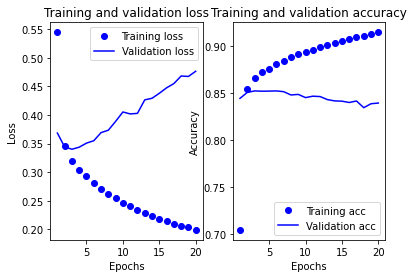

In [22]:
history_chart(history_RNN)

## CNN

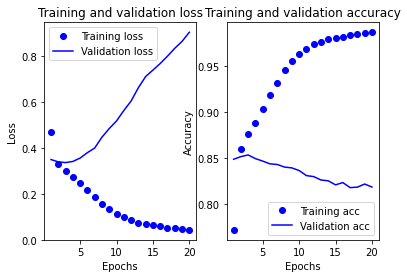

In [23]:
history_chart(history_CNN)

## SG

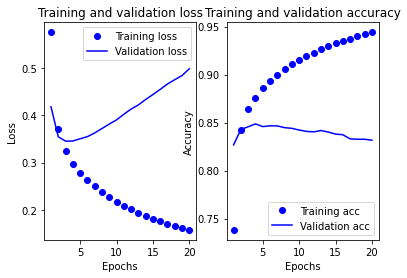

In [24]:
history_chart(history_SG)

## 7) 학습된 Embedding 레이어 분석

---

In [25]:
def Embedding_view(model, word2vec_file_path):
    embedding_layer = model.layers[0]
    weights = embedding_layer.get_weights()[0]
    print(weights.shape)
    
    # 학습한 Embedding 파라미터를 파일에 써서 저장합니다.
    f = open(word2vec_file_path, 'w')
    f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

    # 단어 개수(에서 특수문자 4개는 제외하고) 만큼의 워드 벡터를 파일에 기록합니다.
    vectors = model.get_weights()[0]
    for i in range(4, vocab_size):
        f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
    f.close()
    
    word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
    vector = word_vectors['끝']
    print(vector)
    
    print(word_vectors.similar_by_word("시작"))

In [26]:
word2vec_file_path_RNN = os.getenv("HOME") + '/aiffel/sentiment_classification/data/word2vec_RNN.txt'

Embedding_view(model_RNN, word2vec_file_path_RNN)

(10000, 16)
[ 0.09467404 -0.01140078 -0.09107124 -0.0844694  -0.00354988 -0.00922442
  0.00553751  0.02592501  0.0404499   0.01340989  0.08548209  0.016622
 -0.17229372  0.09045765  0.09469508 -0.04252502]
[('알아듣', 0.8411113619804382), ('호소', 0.8313730955123901), ('얼마나', 0.8294188976287842), ('몸매', 0.8279208540916443), ('원생', 0.8191584944725037), ('뒷맛', 0.8107785582542419), ('됨', 0.8106456398963928), ('늘어놓', 0.807174801826477), ('적응', 0.8040225505828857), ('준거', 0.8022049069404602)]


In [27]:
word2vec_file_path_CNN = os.getenv("HOME") + '/aiffel/sentiment_classification/data/word2vec_CNN.txt'

Embedding_view(model_CNN, word2vec_file_path_CNN)

(10000, 16)
[-0.10729147  0.04498094  0.03333443  0.0185763  -0.03564327  0.02409968
  0.09802046  0.03560832 -0.09469935  0.11438164  0.06317323  0.06442397
 -0.00484771  0.0681879   0.15067454 -0.02401253]
[('잖', 0.8213895559310913), ('찍히', 0.8087561726570129), ('러시아', 0.7860298156738281), ('관리', 0.7689337730407715), ('코난', 0.7612724900245667), ('하하', 0.748289942741394), ('백만', 0.7385641932487488), ('블루', 0.7374067902565002), ('.;;;', 0.7365757822990417), ('노래방', 0.7361742854118347)]


In [28]:
word2vec_file_path_SG = os.getenv("HOME") + '/aiffel/sentiment_classification/data/word2vec_SG.txt'

Embedding_view(model_SG, word2vec_file_path_SG)

(10000, 16)
[-0.26686004 -0.07958845 -0.23931485 -0.12407016 -0.187509   -0.09633507
  0.13420299 -0.02100142 -0.03263157 -0.12726192 -0.00792963 -0.19201834
 -0.23268418 -0.02033907 -0.2456175  -0.04158546]
[('는데', 0.9607604146003723), ('베티', 0.9578509330749512), ('오호', 0.9477537870407104), ('에겐', 0.9460930228233337), ('여인', 0.9414403438568115), ('었', 0.9394529461860657), ('고', 0.9376373887062073), ('팬', 0.9375709891319275), ('보', 0.929472029209137), ('두', 0.9247490763664246)]


## 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

---

* 한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하세요.
* 한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요. 또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다. 좀더 자세한 활용법에 대해선 다음 링크들을 참조해주세요.
[참고 링크1](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#storing-and-loading-models),
[참고 링크2](https://radimrehurek.com/gensim/models/keyedvectors.html)

In [29]:
# 예시 코드
word_vectors = Word2VecKeyedVectors.load('../../data/word2vec_ko.model')
vector = word_vectors.wv['끝']
vector

array([ 1.038851  , -1.1634965 ,  2.2386286 ,  0.8971453 , -2.088168  ,
       -4.1942534 , -0.02519768, -0.69813883, -0.2908033 , -1.4651134 ,
       -2.6863668 ,  0.7999443 , -0.6957915 , -0.5018775 ,  3.5025773 ,
        0.21326113, -0.6588098 , -1.1900496 ,  0.61399573,  2.1247969 ,
        0.1549463 ,  3.0840218 ,  3.1680267 , -3.9143991 ,  3.6073153 ,
        0.5315545 , -0.3511633 , -1.107248  ,  1.7767181 , -0.95981866,
        2.6072454 , -0.00697957, -3.27628   ,  1.558644  ,  0.81922376,
        1.9231955 ,  3.7026553 , -0.53824735, -0.4920138 ,  2.4657123 ,
       -2.620749  , -0.08950733,  0.61453176,  1.8866426 ,  0.257866  ,
       -2.7827141 ,  2.9129577 , -0.6313133 ,  2.0387425 , -4.222685  ,
       -2.7560544 ,  1.7903243 , -1.3080189 , -2.5531402 , -0.43849912,
       -3.1073573 , -0.29090825,  5.1817617 ,  1.9604833 , -5.1421604 ,
       -0.71431434,  4.5624633 , -0.55525815, -3.3019137 ,  1.6761336 ,
       -1.9606539 , -0.2726863 ,  0.2465995 ,  1.2685091 ,  1.60

In [30]:
word_vectors.wv.most_similar('시작')

[('재개', 0.7113743424415588),
 ('개시', 0.6964776515960693),
 ('계속', 0.6593127846717834),
 ('중단', 0.6464443206787109),
 ('진행', 0.6105296611785889),
 ('마무리', 0.5996001958847046),
 ('실시', 0.5984620451927185),
 ('완료', 0.5883207321166992),
 ('전개', 0.5819582343101501),
 ('완성', 0.5794826745986938)]

In [31]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_metrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 복사한다.
for i in range(4, vocab_size):
    if index_to_word[i] in vector:
        embedding_matrix[i] = vector[index_to_word[i]]

/tmp/ipykernel_47/3341942690.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if index_to_word[i] in vector:


In [32]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000
word_vector_dim = 100

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size,
                                   word_vector_dim,
                                   embeddings_initializer=Constant(embedding_metrix),  # 복사한 임베딩을 여기서 활용
                                   input_length=maxlen,
                                   trainable=True))  # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(32, 7, activation='relu', kernel_initializer='he_normal'))
model.add(tf.keras.layers.MaxPooling1D(5))
#model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Conv1D(32, 7, activation='relu', kernel_initializer='he_normal'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
#model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 32)            22432     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 32)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 32)             7200      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [33]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

epochs=10  # 몇 epoch를 훈련하면 좋을지, 조정해봅시다.

history = model.fit(partial_X_train_post,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=128,
                   validation_data=(X_val_post, y_val),
                   verbose=1)

Epoch 1/10
1064/1064 [==============================] - 6s 5ms/step - loss: 0.4868 - accuracy: 0.7405 - val_loss: 0.3931 - val_accuracy: 0.8217
Epoch 2/10
1064/1064 [==============================] - 5s 5ms/step - loss: 0.3373 - accuracy: 0.8538 - val_loss: 0.3506 - val_accuracy: 0.8452
Epoch 3/10
1064/1064 [==============================] - 5s 5ms/step - loss: 0.3034 - accuracy: 0.8730 - val_loss: 0.3397 - val_accuracy: 0.8510
Epoch 4/10
1064/1064 [==============================] - 5s 5ms/step - loss: 0.2739 - accuracy: 0.8884 - val_loss: 0.3572 - val_accuracy: 0.8450
Epoch 5/10
1064/1064 [==============================] - 5s 5ms/step - loss: 0.2437 - accuracy: 0.9042 - val_loss: 0.3889 - val_accuracy: 0.8348
Epoch 6/10
1064/1064 [==============================] - 5s 5ms/step - loss: 0.2104 - accuracy: 0.9193 - val_loss: 0.3832 - val_accuracy: 0.8457
Epoch 7/10
1064/1064 [==============================] - 5s 5ms/step - loss: 0.1775 - accuracy: 0.9349 - val_loss: 0.4345 - val_accuracy:

In [34]:
results = model.evaluate(X_test_post, y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.5797 - accuracy: 0.8258
[0.5796947479248047, 0.8257827162742615]


In [35]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 (변경 가능 하이파라미터)

LSTM_model = tf.keras.Sequential()
LSTM_model.add(tf.keras.layers.Embedding(vocab_size,
                                   word_vector_dim,
                                   embeddings_initializer=Constant(embedding_metrix),  # 복사한 임베딩을 여기서 활용
                                   input_length=maxlen,
                                   trainable=True))
LSTM_model.add(tf.keras.layers.LSTM(64))  # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
LSTM_model.add(tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal'))
LSTM_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
LSTM_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_8 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 1,050,689
Trainable params: 1,050,689
Non-trainable params: 0
_________________________________________________________________


In [36]:
LSTM_model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

epochs=10  # 몇 epoch를 훈련하면 좋을지, 조정해봅시다.

LSTM_history = LSTM_model.fit(partial_X_train_post,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=128,
                   validation_data=(X_val_post, y_val),
                   verbose=1)

Epoch 1/10
1064/1064 [==============================] - 8s 6ms/step - loss: 0.6543 - accuracy: 0.5564 - val_loss: 0.3853 - val_accuracy: 0.8261
Epoch 2/10
1064/1064 [==============================] - 6s 6ms/step - loss: 0.3498 - accuracy: 0.8475 - val_loss: 0.3215 - val_accuracy: 0.8579
Epoch 3/10
1064/1064 [==============================] - 6s 6ms/step - loss: 0.2951 - accuracy: 0.8759 - val_loss: 0.3142 - val_accuracy: 0.8637
Epoch 4/10
1064/1064 [==============================] - 6s 6ms/step - loss: 0.2683 - accuracy: 0.8886 - val_loss: 0.3173 - val_accuracy: 0.8600
Epoch 5/10
1064/1064 [==============================] - 6s 6ms/step - loss: 0.2461 - accuracy: 0.8995 - val_loss: 0.3230 - val_accuracy: 0.8579
Epoch 6/10
1064/1064 [==============================] - 6s 6ms/step - loss: 0.2274 - accuracy: 0.9086 - val_loss: 0.3394 - val_accuracy: 0.8606
Epoch 7/10
1064/1064 [==============================] - 6s 6ms/step - loss: 0.2090 - accuracy: 0.9171 - val_loss: 0.3566 - val_accuracy:

In [37]:
results = LSTM_model.evaluate(X_test_post, y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4199 - accuracy: 0.8507
[0.41988405585289, 0.8506824970245361]


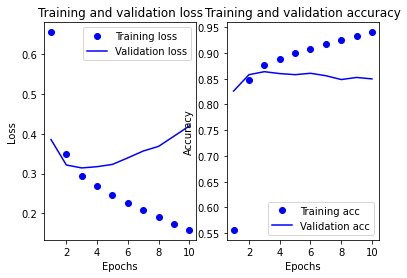

In [38]:
history_chart(LSTM_history)

## 루브릭

평가문항	상세기준
1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.	
3가지 이상의 모델이 성공적으로 시도됨
---
2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.	
gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 비교 분석함   
-> 만들어진 Ebedding layer로 비교분석해야함.  
( 모델은 3개지만 최종적으로는 정확도가 좋은것을 뽑아야하니, 가장 정확도가 높은 모델의 Embedding layer와 비교분석 해야함?)

---
3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.	
네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함  
-> 1개의 모델만 통과하면 됨.